# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


# Dataloader Arguments & Test/Train Split


# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(trainset, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(trainset, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

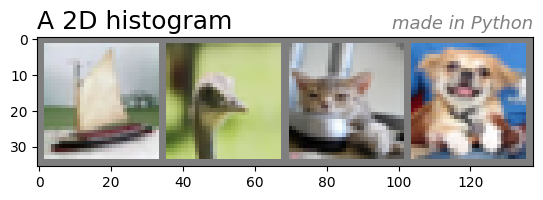

ship  bird  cat   dog  


In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
plt.title("A 2D histogram", loc='left', fontsize=18)

# Second title
plt.title("made in Python", loc='right', fontsize=13, color='grey', style='italic')
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


# The model
Let's start with the model we first saw

In [105]:
# Define a simple CNN with depth-wise convolution
class DepthwiseSeparableConv(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
    super(DepthwiseSeparableConv, self).__init__()
    self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=in_channels)
    self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)

  def forward(self, x):
    x = self.depthwise(x)
    x = self.pointwise(x)
    return x
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()\

        #sequence #

        # Input Block # CONVOLUTION BLOCK 1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, dilation=2, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout2d(0.06),


        ) # output_size = 30

        # CONVOLUTION BLOCK 2
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, dilation=2, kernel_size=(3, 3),  padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.06)
        ) # output_size = 28



         # CONVOLUTION BLOCK 3
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=24, dilation=2, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(24),
            nn.Dropout2d(0.06)
        ) # output_size = 14

         # CONVOLUTION BLOCK 4
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.06)
        ) # output_size = 12

        # CONVOLUTION BLOCK 5
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.06)
        ) # output_size = 10
         # Transition block 1
        self.seq1 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=2, dilation=2, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 28
        # Transition block 2
      #  self.seq2 = DepthwiseSeparableConv(32, 32, 3)
       # self.seq5 = DepthwiseSeparableConv(32, 32, 3)
     #   self.seq2 = nn.Sequential(
      #      nn.Conv2d(in_channels=24, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),

       # ) # output_size =10
        #self.pool2 = nn.MaxPool2d(2, 2) # output_size = 11

         # CONVOLUTION BLOCK 6
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=24, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
           nn.BatchNorm2d(24),
            nn.Dropout2d(0.06)
        ) # output_size = 5

          # CONVOLUTION BLOCK 7
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=32, kernel_size=(3,3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.06)
        ) # output_size = 5
          # CONVOLUTION BLOCK 8
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=24, kernel_size=(3,3),  padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(24),
            nn.Dropout2d(0.06)
        ) # output_size = 5

          #GAP BLOCK
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=10, kernel_size=(3, 3), dilation = 2, padding=1, bias=False),
            nn.AvgPool2d(5),

        ) # output_size = 5
          # OUTPUT LAYER
        self.seq3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), dilation = 1, padding=0, bias=False),
            #nn.AvgPool2d(5)
            # nn.BatchNorm2d(10), NEVER
            # nn.ReLU() NEVER!
        )
    def forward(self, x):

        x = self.convblock1(x)
        print('x_shape:',x.shape)
        x = self.convblock2(x)
        print('x_shape:',x.shape)
        x = self.seq1(x)
        print('x_shape seq1:',x.shape)
        #x = self.pool1(x)

        x = self.convblock3(x)
        print('x_shape :',x.shape)
        x = self.convblock4(x)
        print('x_shape seq1:',x.shape)
        x = self.convblock5(x)
        print('x_shape seq1:',x.shape)
        x = self.seq2(x)
        print('x_shape seq1:',x.shape)
        x = self.seq5(x)
        print('x_shape seq1:',x.shape)

       # x = self.pool1(x)

        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.seq3(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [106]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
x_shape: torch.Size([2, 8, 28, 28])
x_shape: torch.Size([2, 16, 24, 24])
x_shape seq1: torch.Size([2, 2, 24, 24])


RuntimeError: Given groups=1, weight of size [24, 16, 3, 3], expected input[2, 2, 24, 24] to have 16 channels, but got 2 channels instead

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [ ]:
from tqdm import tqdm
import torchvision.transforms.functional as TF
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Train set: Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
index = []
labels = []
pred = []
#wrong_image_list = []
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            # Store wrongly predicted images
            wrong_idx = (pred != target.view_as(pred)).nonzero()[:, 0]
            wrong_samples = data[wrong_idx]
            wrong_preds = pred[wrong_idx]
            actual_preds = target.view_as(pred)[wrong_idx]


              #  re_img = TF.Resize((imsize[i], imsize[i]))(re_img)
              #  img = TF.Resize((28, 28))
             #   wrong_image_list.append(['wrong_idx{}_pred{}_actual{}.png'.format(
              #      wrong_idx[i], wrong_pred.item(), actual_pred.item()),wrong_pred.item(), actual_pred.item()])
               # img.save('wrong_idx{}_pred{}_actual{}.png'.format(
                #    wrong_idx[i], wrong_pred.item(), actual_pred.item()))
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 10
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

In [ ]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")